In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [3]:
messages = [line.rstrip() for line in open('./data/SMSSpamCollection')]
print len(messages)

5574


In [4]:
for message_no, message in enumerate(messages[:10]):
    print message_no, message

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

In [5]:
messages = pandas.read_csv('./data/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print messages

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

In [6]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
messages['length'] = messages['message'].map(lambda text: len(text))
print messages.head()

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


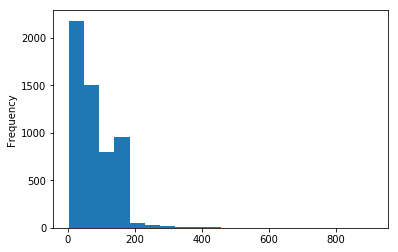

In [8]:
messages.length.plot(bins=20, kind='hist')

In [9]:
messages.length.describe()

count    5574.000000
mean       80.604593
std        59.919970
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [10]:
print list(messages.message[messages.length > 900])

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2463fb90>,
      dtype=object)

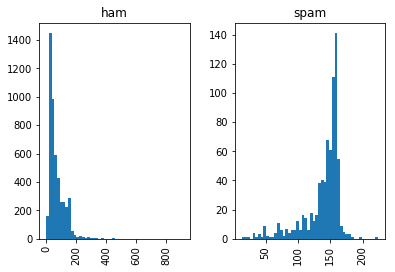

In [11]:
messages.hist(column='length', by='label', bins=50)

In [12]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [13]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [14]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [15]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print len(bow_transformer.vocabulary_)

8859


In [16]:
message4 = messages['message'][3]
print message4

U dun say so early hor... U c already then say...


In [17]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 1158)	1
  (0, 1897)	1
  (0, 2893)	1
  (0, 2923)	1
  (0, 4017)	1
  (0, 6726)	2
  (0, 7101)	1
  (0, 7687)	1
  (0, 8002)	2
(1, 8859)


In [18]:
messages_bow = bow_transformer.transform(messages['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (5574, 8859)
number of non-zeros: 80338
sparsity: 0.16%


In [19]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 8002)	0.30500390244920195
  (0, 7687)	0.22530830435091123
  (0, 7101)	0.19139747787841085
  (0, 6726)	0.5233907074133691
  (0, 4017)	0.4563719925781256
  (0, 2923)	0.329688073969027
  (0, 2893)	0.30370462627268274
  (0, 1897)	0.24665241656533501
  (0, 1158)	0.27494440163841516


In [20]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5574, 8859)


In [21]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 13.3 ms, sys: 1.99 ms, total: 15.3 ms
Wall time: 17.5 ms


In [22]:
print 'predicted:', spam_detector.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: ham
expected: ham


In [23]:
all_predictions = spam_detector.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [24]:
print 'accuracy', accuracy_score(messages['label'], all_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)
print '(row=expected, col=predicted)'

accuracy 0.9695012558306423
confusion matrix
[[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


In [26]:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



In [35]:
import pandas as pd

In [37]:
df = pd.read_csv('./data/SMSSpamCollection', sep='\t', header=-1)
df.columns = ['class','text']

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("The Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [42]:
msgs = pd.read_csv('./data/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,names=["label", "message"])

m_trn, m_tst, l_trn, l_tst = \
    train_test_split(msgs['message'], msgs['label'], test_size=0.2)

In [44]:
classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    MultinomialNB()]
names_classifier = ['Linear SVM','RBF SVM', 'Naive Bayes']

Complete Data Set:
Linear SVM 0.8659369943080726 0.0003806035861213711


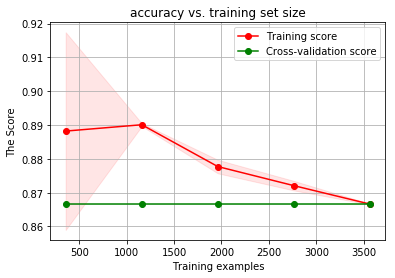

RBF SVM 0.9644657880541981 0.0023030243355415987


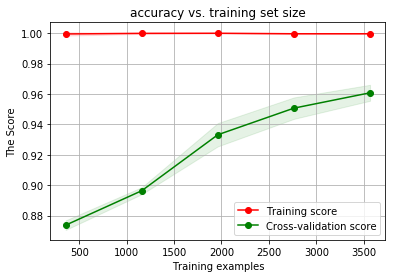

Naive Bayes 0.9580042025263463 0.0026265962389285936


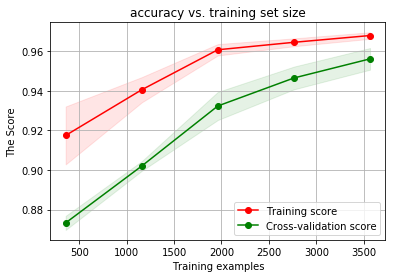

In [52]:
print "Complete Data Set:"
for i,classifier in enumerate(classifiers):
    pipeline=Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('classifier', classifier)])
    scores=cross_val_score(pipeline, df['text'], df['class'], cv=5, scoring='accuracy', n_jobs=-1)
    print names_classifier[i], scores.mean(), scores.std()
    plot_learning_curve(pipeline, "accuracy vs. training set size", m_trn, l_trn, cv=5)
    plt.show()



Training Data and Validation Data:
Linear SVM 0.8665619825560036 5.989139023516721e-05


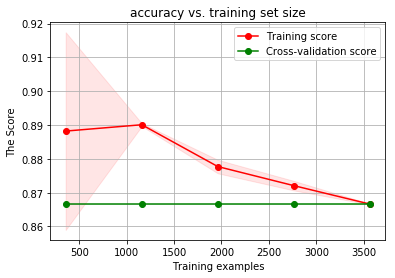

RBF SVM 0.9609784944613047 0.005367132054152973


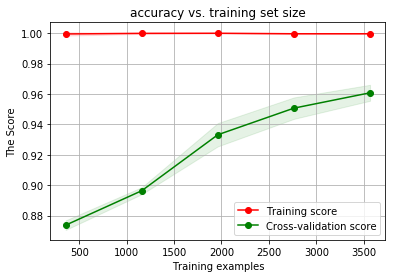

Naive Bayes 0.956044249168315 0.0054622786750225215


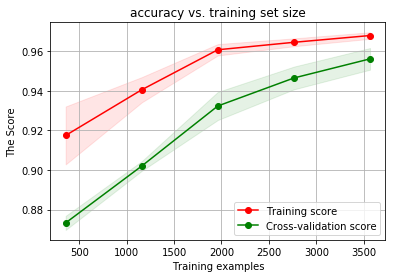

In [51]:
print "Training Data and Validation Data:"
for i,classifier in enumerate(classifiers):
    pipeline=Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('classifier', classifier)])
    scores=cross_val_score(pipeline, m_trn, l_trn, cv=5, scoring='accuracy', n_jobs=-1)
    print names_classifier[i], scores.mean(), scores.std()
    plot_learning_curve(pipeline, "accuracy vs. training set size", m_trn, l_trn, cv=5)
    plt.show()


In [55]:
pipeline = Pipeline([('bow', CountVectorizer(analyzer=split_into_lemmas)), ('tfidf', TfidfTransformer()), ('classifier', MultinomialNB())])
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(l_trn, n_folds=5),  # what type of cross validation to use
)

In [59]:
grid = GridSearchCV(
    pipeline, params, refit=True, n_jobs=-1,
    scoring='accuracy',		cv=StratifiedKFold(l_trn, n_folds=5),)

nb_detector = grid.fit(m_trn, l_trn)
predictions = nb_detector.predict(m_tst)
print "Naive Bayes:"
print 'accuracy', accuracy_score(l_tst, predictions)
print confusion_matrix(l_tst, predictions)
print classification_report(l_tst, predictions)

Naive Bayes:
accuracy 0.9533632286995516
[[963   0]
 [ 52 100]]
             precision    recall  f1-score   support

        ham       0.95      1.00      0.97       963
       spam       1.00      0.66      0.79       152

avg / total       0.96      0.95      0.95      1115



In [56]:
%time nb_detector = grid.fit(m_trn, l_trn)
print nb_detector.grid_scores_

CPU times: user 3.17 s, sys: 106 ms, total: 3.28 s
Wall time: 25.9 s
[mean: 0.94864, std: 0.00508, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x1a2463b578>}, mean: 0.92980, std: 0.00515, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x1a2463b578>}, mean: 0.94685, std: 0.00457, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x1a245c40c8>}, mean: 0.92868, std: 0.00578, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x1a245c40c8>}]


In [57]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),])

param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(l_trn, n_folds=5),  # what type of cross validation to use
)

In [61]:
%time svm_detector = grid_svm.fit(m_trn, l_trn) # find the best combination from param_svm
print svm_detector.grid_scores_

CPU times: user 4.45 s, sys: 306 ms, total: 4.76 s
Wall time: 1min 34s
[mean: 0.98453, std: 0.00509, params: {'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.98408, std: 0.00547, params: {'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.98408, std: 0.00547, params: {'classifier__kernel': 'linear', 'classifier__C': 100}, mean: 0.98408, std: 0.00547, params: {'classifier__kernel': 'linear', 'classifier__C': 1000}, mean: 0.86656, std: 0.00006, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86656, std: 0.00006, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86656, std: 0.00006, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.86656, std: 0.00006, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.96905, std: 0.00758, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'r

In [60]:
grid_svm = GridSearchCV(
        pipeline_svm, param_grid=param_svm, refit=True, n_jobs=-1, scoring='accuracy', cv=StratifiedKFold(l_trn, n_folds=5),)

svm_detector = grid_svm.fit(m_trn, l_trn)
print "SVM:"
print 'accuracy', accuracy_score(l_tst, svm_detector.predict(m_tst))
print confusion_matrix(l_tst, svm_detector.predict(m_tst))
print classification_report(l_tst, svm_detector.predict(m_tst))

SVM:
accuracy 0.9856502242152466
[[960   3]
 [ 13 139]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       963
       spam       0.98      0.91      0.95       152

avg / total       0.99      0.99      0.99      1115

